In [673]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.misc import imread, imresize, imshow
from skimage import io
import cv2
import os
import time
from hashlib import md5
import scipy

In [674]:
CHANGE_RATE = 0.065
TUMBNAIL_SIZE = 20
SUB_IMAGE_CENTER = (int(1920 / 2), int(1080 / 2) + 100)
SUB_IMAGE_RADIUS = 250

In [ ]:
IMAGE_DIR =  os.path.join(os.environ.get("HOME_PATH"), 'pipeline\\2. frames')

os.chdir(IMAGE_DIR)
os.getcwd()

In [676]:
image_file_names = os.listdir()


In [677]:
image_file_names[0]

'20190330_165251_EF.mp4.frame-001.png'

In [678]:
io.imread(image_file_names[0]).shape

(1080, 1920, 3)

In [679]:
def filter_images(image_file_names):
    image_list= []
    for image_file_name in image_file_names:
        try:
            assert io.imread(image_file_name).shape[2] == 3
            image_list.append(image_file_name)
        except AssertionError as e:
            print(e)
    return image_list
            

In [680]:
def get_sub_image(image):
    left = SUB_IMAGE_CENTER[0] - SUB_IMAGE_RADIUS
    width = left + SUB_IMAGE_RADIUS * 2
    top = SUB_IMAGE_CENTER[1] - SUB_IMAGE_RADIUS
    height = top + SUB_IMAGE_RADIUS * 2

    return image[top:height,left:width,:] 

In [681]:
def img_gray(image):    
    return np.average(image, weights=[0.299, 0.587, 0.114], axis=2)

In [682]:
def resize_image(image, height=TUMBNAIL_SIZE, width=TUMBNAIL_SIZE):
    row_res = cv2.resize(image, (height, width), interpolation = cv2.INTER_AREA).flatten()
    col_res = cv2.resize(image, (height, width), interpolation = cv2.INTER_AREA).flatten('F')
    return row_res, col_res

In [683]:
def intensity_diff(row_res, col_res):
    # Checks if neighbor pixel is greater or less.
    difference_row = np.diff(row_res)
    difference_col = np.diff(col_res)
    difference_row = difference_row > 0
    difference_col = difference_col > 0
    return np.vstack((difference_row, difference_col)).flatten()

In [684]:
def difference_score(image_file_name, height = TUMBNAIL_SIZE, width = TUMBNAIL_SIZE):
    image = io.imread(image_file_name)
    sub_image = get_sub_image(image)
    gray = img_gray(sub_image)    
    row_res, col_res = resize_image(sub_image, height, width)
    difference = intensity_diff(row_res, col_res)
    
    return difference

In [685]:
def file_hash(array):
    return md5(array).hexdigest()

In [686]:
def difference_score_dict(image_file_names):
    ds_dict = {}
    duplicates = []
    for image_file_name in image_file_names:
        ds = difference_score(image_file_name)
        
        if image_file_name not in ds_dict:
            ds_dict[image_file_name] = ds
        else:
            duplicates.append((image_file_name, ds_dict[image_file_name]) )
    
    return  duplicates, ds_dict

In [687]:
# def difference_score_dict_hash(image_file_names):
#     ds_dict = {}
#     duplicates = []
#     hash_ds = []
#     for image_file_name in image_file_names:
#         ds = difference_score(image_file_name)
#         hash_ds.append(ds)
#         filehash = md5(ds).hexdigest()
#         if filehash not in ds_dict:
#             ds_dict[filehash] = image_file_name
#         else:
#             duplicates.append((image_file_name, ds_dict[filehash]) )
    
#     return  duplicates, ds_dict, hash_ds

In [688]:
def hamming_distance(image, image2):
    score = scipy.spatial.distance.hamming(image, image2)
    return score

In [689]:
duplicates, ds_dict = difference_score_dict(image_file_names)
print(duplicates)
print(len(ds_dict))

[]
211


In [690]:
hash_filename_list = []

for key, value in ds_dict.items():
    temp = [key,value]
    hash_filename_list.append((key, value))

hash_filename_list[:5]

[('20190330_165251_EF.mp4.frame-001.png',
  array([ True,  True,  True, ...,  True,  True,  True])),
 ('20190330_165251_EF.mp4.frame-003.png',
  array([ True,  True,  True, ...,  True,  True,  True])),
 ('20190330_165251_EF.mp4.frame-004.png',
  array([ True,  True,  True, ...,  True,  True,  True])),
 ('20190330_165251_EF.mp4.frame-005.png',
  array([ True,  True,  True, ...,  True,  True,  True])),
 ('20190330_165251_EF.mp4.frame-006.png',
  array([ True,  True,  True, ...,  True, False,  True]))]

In [691]:
base_file_name_a, base_score_a = hash_filename_list[0]
base_file_name_b, base_score_b = hash_filename_list[83]
print(base_file_name_a, base_file_name_b)
print(base_score_a)
print(base_score_b)

20190330_165251_EF.mp4.frame-001.png 20190330_165451_NF.mp4.frame-009.png
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]


In [692]:
hamming_distance(base_score_a, base_score_b)

0.05004170141784821

In [716]:
unique_images = []
similar_images = []

base_file_name, base_score = hash_filename_list[0]
unique_images.append(base_file_name)
hd_list = []
for file_name, file_score in hash_filename_list[1:]:
    hd = hamming_distance(base_score, file_score)
    hd_list.append(hd)
    if(hd > CHANGE_RATE ):
        base_file_name = file_name
        base_score = file_score    
        unique_images.append(file_name)
    else:
        similar_images.append(file_name)


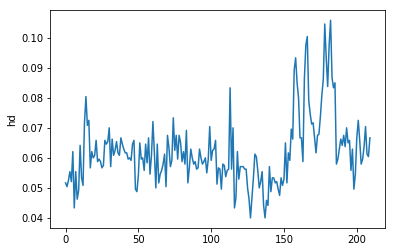

In [717]:
plt.plot(hd_list)
plt.ylabel('hd')
plt.show()

In [718]:
print(len(unique_images), len(similar_images))


66 145


In [696]:

# for file_name in unique_images[:20]:
#     try:
        
#         plt.figure(figsize=(40, 40))
#         plt.subplot(121),plt.imshow(imread(file_name))
#         plt.title(file_name), plt.xticks([]), plt.yticks([])
#         plt.show()
#         i += 1
    
#     except OSError as e:
#         continue

In [697]:


# unique_images = []
# base_hash, base_image = hash_filename_list[0]

# unique_images.append(base_image)
# for _hash, image in hash_filename_list[1:]:
#     if hamming_distance(base_hash, _hash) > .99:
#         base_hash = _hash
#         unique_images.append(image)
        
# print(unique_images)

In [698]:
# image_files = filter_images(image_files)
# duplicates, ds_dict, hash_ds =difference_score_dict_hash(image_files)

In [699]:
# duplicates

In [700]:
# ds_dict
# '215c636223a7a0fb9703bf9cb0dded80': 'frame-001.png'

In [701]:
#hash_ds

In [702]:
# image_files = filter_images(image_files)
# duplicates, ds_dict =difference_score_dict(image_files)

In [703]:
# import itertools
# duplicates = []

In [704]:

# for k1,k2 in itertools.combinations(ds_dict, 2):
#     if hamming_distance(ds_dict[k1], ds_dict[k2]) < .02:
#         duplicates.append((k1,k2))

In [705]:
# print(len(ds_dict))
# print(len(duplicates))

In [706]:
# hamming_distance(ds_dict['frame-001.png'], ds_dict['frame-054.png'])

In [707]:
image = io.imread(image_file_names[83])
sub_image = get_sub_image(image)

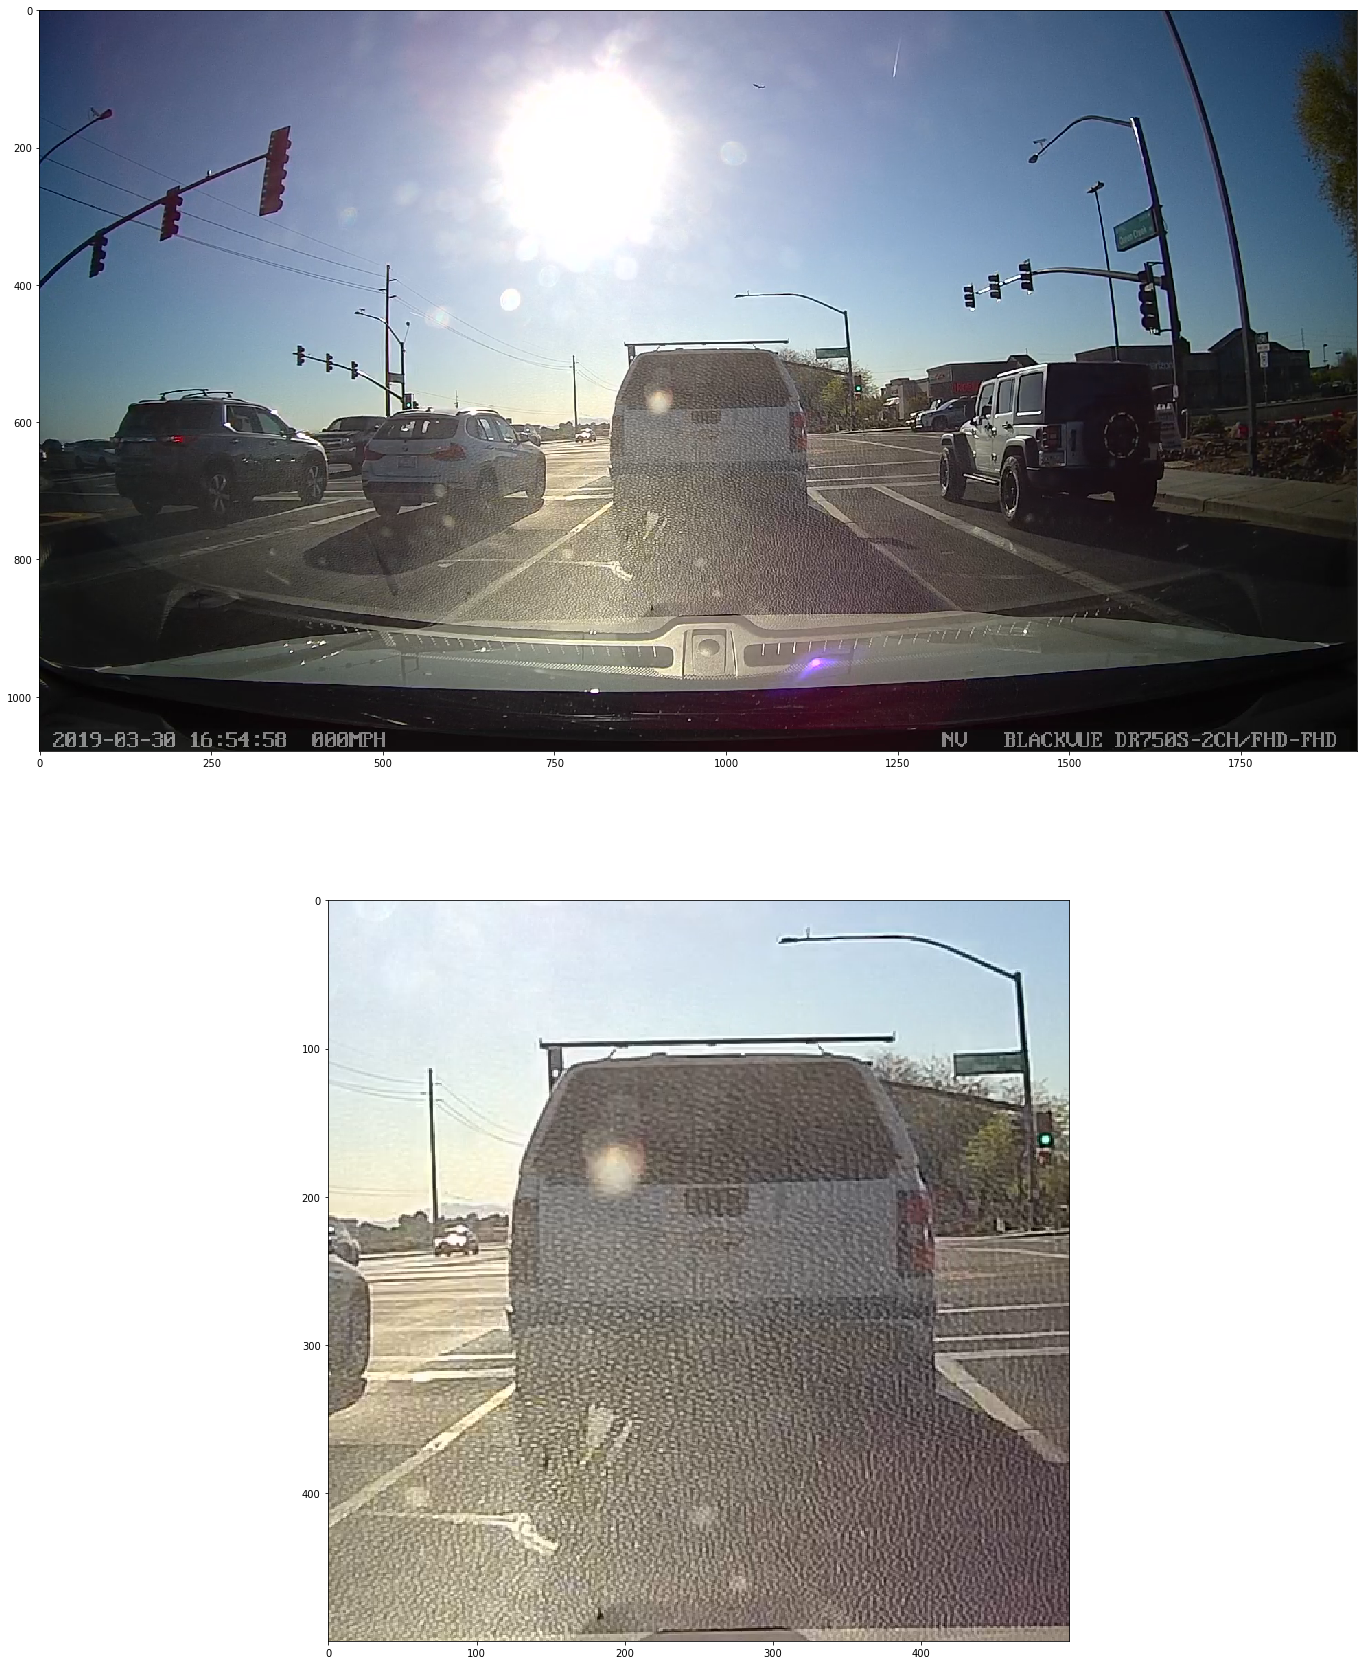

In [708]:
fig=plt.figure(figsize=(30, 30))
columns = 1
rows = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(image)
fig.add_subplot(rows, columns, 2)
plt.imshow(sub_image, cmap=plt.cm.gray)

In [719]:
import shutil
HOME = os.environ.get("HOME_PATH")
FRAME_PATH_DISTINCT = os.path.join(HOME, "pipeline", "2. frames_distinct")
FRAME_PATH_SIMILAR_DROP = os.path.join(HOME, "pipeline", "2. frames_similar_drop")

for file_name in unique_images:
    shutil.move(os.path.join(os.getcwd(),file_name), FRAME_PATH_DISTINCT)
    
for file_name in similar_images:
    shutil.move(os.path.join(os.getcwd(),file_name), FRAME_PATH_SIMILAR_DROP)